# Hyperparameter tune VIT model on All Hurricanes

In [66]:
import os
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import MultiPolygon, Polygon
import shapely
from shapely import wkt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch import tensor

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms, utils
import torch.utils.data
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torchsummary import summary

import cv2
from PIL import Image

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where

import optuna

import joblib

from datetime import date
# from skorch import NeuralNetClassifier
# from skorch.helper import predefined_split
# from skorch.callbacks import LRScheduler, Checkpoint, Freezer, EarlyStopping
# from sklearn.model_selection import GridSearchCV






torch.manual_seed(360);

### Setup Current Directory

In [ ]:
print("Current Path : ", os.getcwd())
os.chdir('../..')
print("Current Path : ", os.getcwd())

In [ ]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'xview_building_damage')
CSV_DIR = os.path.join(ROOT_DATA_DIR, 'csv')
print("Data CSV Path : ", CSV_DIR)
TRAIN_DIR=os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DIR)
HOLD_DIR=os.path.join(ROOT_DATA_DIR, 'hold')
print("Validation Data Path : ", HOLD_DIR)
TEST_DIR=os.path.join(ROOT_DATA_DIR, 'test')
print("Test Data Path : ", TEST_DIR)

### Load the data

In [ ]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)
    
    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [ ]:
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

valid_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [78]:
train_all_dataset = datasets.ImageFolder(os.path.join(TRAIN_DIR, 'img_mask_ov_crop_class'), transform=train_transform)
valid_all_dataset = datasets.ImageFolder(os.path.join( HOLD_DIR, 'img_mask_ov_crop_class'), transform=valid_transform)
test_all_dataset = datasets.ImageFolder(os.path.join( TEST_DIR, 'img_mask_ov_crop_class'), transform=test_transform)


print("Train set records : ", len(train_all_dataset))
print("Validation set records : ", len(valid_all_dataset))
print("Test set records : ", len(test_all_dataset))

#trainset_all = torch.utils.data.Subset(train_all_dataset, list(range(len(train_all_dataset))))
#testset_all = torch.utils.data.Subset(test_all_dataset, list(range(len(test_all_dataset))))
#validset_all = torch.utils.data.Subset(valid_all_dataset, list(range(len(valid_all_dataset))))

#sampler = torch.utils.data.sampler.WeightedRandomSampler(element_weights, num_epoch_elements, replacement=False)

batch_size = 128

# prepare data loaders
train_loader_all = DataLoader(trainset_all, batch_size=batch_size, num_workers=2)
valid_loader_all = DataLoader(validset_all, batch_size=batch_size, num_workers=2)
test_loader_all = DataLoader(testset_all, batch_size=batch_size, num_workers= 2)

Train set records :  64454
Validation set records :  22107
Test set records :  19299


In [84]:
test_fileNames = test_all_dataset.imgs

In [ ]:
class_names = train_all_dataset.classes
print("class_names ",class_names)

class_dict = train_all_dataset.class_to_idx
print("class_dict ",class_dict)

In [ ]:
print("================================================")
print(f"Train data:\n{train_all_dataset}")
print(f"Validation data:\n{valid_all_dataset}")
print(f"Test data:\n{test_all_dataset}")

In [ ]:
train_all_labels, train_all_labels_count = get_label_stats(train_loader_all)

In [ ]:
valid_all_labels, valid_all_labels_count = get_label_stats(valid_loader_all)

In [ ]:
test_labels, test_labels_count = get_label_stats(test_loader_all)

In [ ]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)
    
    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    return class_weights

In [ ]:
class_weights_all=get_class_weights(train_all_labels)
print("Class weights", class_weights_all)

class_weights_all = torch.tensor(class_weights_all, dtype=torch.float32).to('cpu')
# balanced sampler
weights_all = class_weights_all[train_all_labels]
ws_all = WeightedRandomSampler(weights_all, len(weights_all), replacement=True)

In [ ]:
train_loader_ws_all = DataLoader(trainset_all, batch_size=batch_size, sampler=ws_all , num_workers=2)

In [ ]:
train_labels_ws_all, train_labels_count_ws_all = get_label_stats(train_loader_ws_all)

#train_labels_ws, train_labels_count_ws = get_label_stats(train_loader_ws)

In [ ]:
len(valid_loader_all)

In [ ]:
len(test_loader_all)

### Model Training

In [88]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    
    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)
    
    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")
    
    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")
    
    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)
    return accuracy, f1_score, precision, recall

In [89]:
def get_F1Score(preds_list, target_list, num_classes = 4):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    return multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")

In [90]:
def get_Accuracy(preds_list, target_list, num_classes = 4):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    return multiclass_accuracy(pred_ts, target_ts, num_classes=4)

In [91]:
def get_Precision(preds_list, target_list, num_classes = 4):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    return multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")

In [92]:
def get_Recall(preds_list, target_list, num_classes = 4):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    return multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")

In [93]:
model_name = "vit_base_patch16_224"
def setup_device():
    device = 'cpu' 
    if torch.cuda.is_available(): 
     device='cuda'
    elif torch.backends.mps.is_available():
     device = 'mps' 
    
    print("device = ", device)
    return device

In [94]:
def get_vit_model():
    vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    print("=============================== Model heads ==========================")
    print(vision_transformer.heads)
    # fine-tune with dataset

    # change the number of output classes
    vision_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names), bias=True)
    
    # freeze the parameters except the last linear layer
    #
    # freeze weights
    for p in vision_transformer.parameters():
        p.requires_grad = False
    
    # unfreeze weights of classification head to train
    for p in vision_transformer.heads.parameters():
        p.requires_grad = True

    print("=============================== Model Layers ==========================")
    for layer_name, p in vision_transformer.named_parameters():
        print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
        print()

    return vision_transformer

In [95]:
def get_vit_model_with_classes(number_of_classes=4):
    vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    # fine-tune with dataset
    # change the number of output classes
    vision_transformer.heads = nn.Linear(in_features=768, out_features=number_of_classes, bias=True)
    
    # freeze the parameters except the last linear layer
    #
    # freeze weights
    for p in vision_transformer.parameters():
        p.requires_grad = False
    
    # unfreeze weights of classification head to train
    for p in vision_transformer.heads.parameters():
        p.requires_grad = True

    return vision_transformer

In [97]:
def get_focal_loss(ce_loss, alpha =0.3 ,gamma =2):
    pt = torch.exp(-ce_loss)
    focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()
    return focal_loss;

In [98]:
def plot_losses(train_loss_list, valid_loss_list, n_epoch, title):
    plt.title("Training and Validation "+title)
    plt.xlabel("Epoch")
    plt.ylabel(title)
    
    # plot losses
    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_loss_list, color ="blue", label='Train')
    plt.plot(x, valid_loss_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)
    
    plt.show()

In [99]:
def accuracy_per_class(class_correct, class_total, class_names, accuracy ):
    n_class = len(class_names)

    class_accuracy = class_correct / class_total

    print('Test Accuracy of Classes')
    print()
    
    for c in range(n_class):
        print('{}\t: {}% \t ({}/{})'.format(class_names[c],
                                    int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )
    
    print()
    print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                               int(np.sum(class_correct)), int(np.sum(class_total)) ))
    

In [87]:
vision_transformer = get_vit_model()

=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

In [125]:
def save_model(model, filename):
    print("Started : Saving the trained Model")
    joblib.dump(model, filename)
    print("Finished : Saving the trained Model")

In [103]:
final_pred_list = []
final_target_list = []

In [131]:

def train_eval_model(device, 
                     optimizer, 
                     criterion ,
                     train_on_gpu, 
                     class_weights, 
                     valid_loader,
                     test_loader, 
                     model=vision_transformer,  
                     n_epoch = 15,
                     data = train_loader_ws_all):
    
    train_loss_list, valid_loss_list = [], []
    # train_focal_loss_list, valid_focal_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        model.to(device)
    
    # prepare model for training
    model.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
        # train_focal_loss = 0.0
        # valid_focal_loss =0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = model(images)
    
            # calculate loss
            loss = criterion(outputs, targets)

            #fl = get_focal_loss(loss)
    
            # backward pass, calculate gradients
            loss.backward()
            #fl.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
            #train_focal_loss += fl.item()
    
        # set model to evaluation mode
        model.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = model(images)
                loss = criterion(outputs, targets)
                #fl = get_focal_loss(loss)
                valid_loss += loss.item()
                #valid_focal_loss += fl.item()
    
        # set model back to training mode
        model.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)

        # train_focal_loss = train_focal_loss/len(data)
        # valid_focal_loss = valid_focal_loss/len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        # train_focal_loss_list.append(train_focal_loss)
        # valid_focal_loss_list.append(valid_focal_loss)
    
        # output training statistics for epoch
        print('Epoch: {}'.format((e+1)))
        print('\t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format(  train_loss, valid_loss))
        # print('\t Training Focal Loss: {:.6f} \t Validation Focal Loss: {:.6f}'
        #       .format( train_focal_loss, valid_focal_loss))
    
    plot_losses(train_loss_list, valid_loss_list, n_epoch, 'Loss')
    # plot_losses(train_focal_loss_list, valid_focal_loss_list, n_epoch, 'Focal Loss')
    # prepare model for evaluation
    model.eval()
    
    class_weights = class_weights.to('cpu')
    preds_list = []
    target_list = []
    output_list = []
    
    test_loss = 0.0
    # test_focal_loss = 0.0
    accuracy = 0
    
    # number of classes
    n_class = len(class_names)
    
    class_correct = np.zeros(n_class)
    class_total = np.zeros(n_class)
    
    # move model back to cpu
    model = model.to('cpu')
    
    # test model
    for images, targets in test_loader:
    
        # get outputs
        outputs = model(images)
    
        # calculate loss
        loss = criterion(outputs, targets)
        # fl = get_focal_loss(loss)
    
        # track loss
        test_loss += loss.item()
        #test_focal_loss += fl.item()
        
        # get predictions from probabilities
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
        target_list.extend(targets)
        output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
        preds_list.extend(preds)
    
        # get correct predictions
        correct_preds = (preds == targets).type(torch.FloatTensor)
    
        # calculate and accumulate accuracy
        accuracy += torch.mean(correct_preds).item() * 100
    
        # calculate test accuracy for each class
        for c in range(n_class):
    
            targets = targets.to('cpu')
    
            class_total[c] += (targets == c).sum()
            class_correct[c] += ((correct_preds) * (targets == c)).sum()
    
    # get average accuracy
    accuracy = accuracy / len(test_loader)
    
    # get average loss
    test_loss = test_loss / len(test_loader)

    # test_focal_loss = test_focal_loss/ len(test_loader)
    
    # output test loss statistics
    print('Test Loss: {:.6f}'.format(test_loss))
    # print('Test Focal Loss: {:.6f}'.format(test_focal_loss))
    
    accuracy_per_class(class_correct, class_total, class_names, accuracy)
    
    get_metrics(preds_list, target_list)
    today = date.today()
    
    final_pred_list = preds_list
    final_target_list = target_list
    
    print("Saving ...")
    print("vit"+str(today)+".pkl")
    save_model(model, 'vit'+str(today)+'.pkl')
    print("Finished ...")
    
    return preds_list, target_list

### Model Training Parameters

In [ ]:
criterion = nn.CrossEntropyLoss()

# define optimizer
lrs = [0.00001, 0.0001, 0.005, 0.001, 0.02 ,0.01, 0.1, 0.2, 0.5]
epoches = [5, 10, 15, 25, 30, 50, 75, 100]

lambda_norm = [ 0.025, 0.035, 0.045, 0.05, 0.075]
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws_all), epoches[2], lambda_norm[0])
print("Lambda weight Decay", lambda_wd)

optimizer_0 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_1 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.001)
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_3 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.001,  weight_decay=0.1)
optimizer_4 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1, amsgrad=True)
optimizer_5 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1,betas= (0.9,0.999), amsgrad=True)

### Manual Hyperparameter Tuning

In [ ]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=0.1)
train_on_gpu = torch.backends.mps.is_available()

In [ ]:
print("Epoches : ", epoch)
print("Constant Weight Decay 0.1")
print(optimizer)

In [ ]:
train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all, 
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

#### Configuration 2

In [ ]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

In [ ]:
print("Epoches : ", epoch)
print("Weight Decay", lambda_wd)
print(optimizer)

In [ ]:
train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all, 
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

### Optuna

In [ ]:

DEVICE = setup_device()  ##'cuda' or 'cpu'
BATCHSIZE = 128
CLASSES = 4   #CLASSES = 10 for cifar10 and 100 for cifar100
DIR = os.getcwd()
EPOCHS = 15
LOG_INTERVAL = 15
N_TRAIN_EXAMPLES = BATCHSIZE * 504
N_VALID_EXAMPLES = BATCHSIZE * 173
N_TEST_EXAMPLES = BATCHSIZE * 151

In [ ]:
def objective(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    #lr = 0.001
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error

    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            val_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy #val_loss_epoch

In [ ]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
study.best_trial

In [ ]:
optuna.visualization.plot_optimization_history(study)   

In [ ]:
optuna.visualization.plot_param_importances(study) 

In [ ]:
optuna.visualization.plot_slice(study) 

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

### Optuna Multiobjective function

### Maximizing F1-Score

In [44]:
def objective(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "AdamW"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        f1Score = get_F1Score(preds_list, target_list)
        
        trial.report(f1Score, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1Score #val_loss_epoch

In [45]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objective, n_trials=30, timeout=600)

[I 2024-03-31 12:11:17,977] A new study created in memory with name: no-name-ece8a14f-ab22-4fdd-a1ff-5617b9dcdc8f


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

[I 2024-03-31 14:40:00,999] Trial 0 finished with value: 0.5250606536865234 and parameters: {'optimizer': 'AdamW', 'lr': 0.0009608670155124675, 'weight_decay': 1.055065347024647}. Best is trial 0 with value: 0.5250606536865234.


In [46]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.5250606536865234
  Params: 
    optimizer: AdamW
    lr: 0.0009608670155124675
    weight_decay: 1.055065347024647


### SGD With momemtum

In [59]:
def objective_f1(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "SGD"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    montum = trial.suggest_float("momentum", 0.5, 0.99, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd, momentum=montum )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        f1Score = get_F1Score(preds_list, target_list)
        
        trial.report(f1Score, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1Score #val_loss_epoch

In [60]:
study_sgd = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study_sgd.optimize(objective_f1, n_trials=25, timeout=600)

[I 2024-04-01 19:07:39,089] A new study created in memory with name: no-name-ffb46ab3-f0d7-4798-81c3-6ae67870a36a


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

[I 2024-04-01 21:49:43,360] Trial 0 finished with value: 0.47744783759117126 and parameters: {'optimizer': 'SGD', 'lr': 0.004370372043736819, 'weight_decay': 0.01965512381896859, 'momentum': 0.8746091918588648}. Best is trial 0 with value: 0.47744783759117126.


In [61]:
pruned_trials = [t for t in study_sgd.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_sgd.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study_sgd.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study_sgd.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.47744783759117126
  Params: 
    optimizer: SGD
    lr: 0.004370372043736819
    weight_decay: 0.01965512381896859
    momentum: 0.8746091918588648


### Maximizing Accuracy

In [47]:
def objective_ACC(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "AdamW"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        acc_from = get_Accuracy(preds_list, target_list)
        
        trial.report(acc_from, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return acc_from #val_loss_epoch

In [48]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objective_ACC, n_trials=30, timeout=600)

[I 2024-03-31 14:40:01,013] A new study created in memory with name: no-name-2b97b55f-4495-470d-b44f-fd27610f1f59


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

[I 2024-03-31 17:09:43,096] Trial 0 finished with value: 0.44950515031814575 and parameters: {'optimizer': 'AdamW', 'lr': 0.0004856281969016132, 'weight_decay': 1.644097743054941}. Best is trial 0 with value: 0.44950515031814575.


In [49]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.44950515031814575
  Params: 
    optimizer: AdamW
    lr: 0.0004856281969016132
    weight_decay: 1.644097743054941


### Maximizing Precision

In [50]:
def objectivePrecision(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "AdamW"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        precision = get_Precision(preds_list, target_list)
        
        trial.report(precision, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return precision #val_loss_epoch

In [51]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objectivePrecision, n_trials=30, timeout=600)

[I 2024-03-31 17:09:43,109] A new study created in memory with name: no-name-4aa8073a-75a5-460d-8d4c-3a994fa438e3


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

[I 2024-03-31 19:47:42,063] Trial 0 finished with value: 0.5347465872764587 and parameters: {'optimizer': 'AdamW', 'lr': 0.06766327115344287, 'weight_decay': 0.27636857816992544}. Best is trial 0 with value: 0.5347465872764587.


In [52]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.5347465872764587
  Params: 
    optimizer: AdamW
    lr: 0.06766327115344287
    weight_decay: 0.27636857816992544


### Maximizing Recall

In [53]:
def objectiveRecall(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "AdamW"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        recall = get_Recall(preds_list, target_list)
        
        trial.report(recall, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return recall #val_loss_epoch

In [54]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objectiveRecall, n_trials=30, timeout=600)

[I 2024-03-31 19:47:42,079] A new study created in memory with name: no-name-531ff6d0-523f-4c67-a5ff-cdf83f659095


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

[I 2024-03-31 22:13:10,114] Trial 0 finished with value: 0.369500994682312 and parameters: {'optimizer': 'AdamW', 'lr': 0.008610244361088797, 'weight_decay': 0.03878816865309492}. Best is trial 0 with value: 0.369500994682312.


In [55]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.369500994682312
  Params: 
    optimizer: AdamW
    lr: 0.008610244361088797
    weight_decay: 0.03878816865309492


### Minimizing Loss

In [ ]:
def objective(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", [ "AdamW"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    wd = trial.suggest_float("weight_decay",0.01 ,2, log=True ) 
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd )
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error
    
    train_loss_list, valid_loss_list = [], []
    # Get the MNIST dataset.
    train_loader, valid_loader, test_loader = train_loader_ws_all, valid_loader_all, test_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            train_loss = 0.0
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation of the model.
        model.eval()
        correct = 0
        preds_list = []
        target_list = []
        
        with torch.no_grad():
            test_loss_batch = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                target_list.extend(target)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                preds_list.extend(pred)
                test_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss = test_loss_batch / len(test_loader)
        valid_loss_list.append(valid_loss)
        recall = get_Recall(preds_list, target_list)
        
        trial.report(recall, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return recall #val_loss_epoch

### Saving the Best Model

In [113]:
# define optimizer
lrs = 0.0009608670155124675
epoches = 30

lambda_norm = [1.055065347024647,  0.05, ]

lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws_all), epoches, lambda_norm[1])
print("Lambda weight Decay", lambda_wd)
print("learning rate ", lrs)

optimizer_1 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0009608670155124675,  weight_decay=lambda_wd)
optimizer_2 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0009608670155124675,  weight_decay=lambda_wd, amsgrad=True)

Lambda weight Decay 0.004600437062282361
learning rate  0.0009608670155124675


In [116]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches
criterion = nn.CrossEntropyLoss()
optimizer = optimizer_1
train_on_gpu = torch.backends.mps.is_available()

device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encode

In [117]:
print("Optimizer " , optimizer)

Optimizer  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0009608670155124675
    maximize: False
    weight_decay: 0.004600437062282361
)


Device available :  mps
Epoch: 1
	 Training Loss: 1.541453 	 Validation Loss: 1.558908
Epoch: 2
	 Training Loss: 1.542236 	 Validation Loss: 1.558796
Epoch: 3
	 Training Loss: 1.540509 	 Validation Loss: 1.558711
Epoch: 4
	 Training Loss: 1.538595 	 Validation Loss: 1.558719
Epoch: 5
	 Training Loss: 1.539716 	 Validation Loss: 1.558776
Epoch: 6
	 Training Loss: 1.539482 	 Validation Loss: 1.558771
Epoch: 7
	 Training Loss: 1.546008 	 Validation Loss: 1.559042
Epoch: 8
	 Training Loss: 1.541208 	 Validation Loss: 1.558932
Epoch: 9
	 Training Loss: 1.543900 	 Validation Loss: 1.558643
Epoch: 10
	 Training Loss: 1.542546 	 Validation Loss: 1.558603
Epoch: 11
	 Training Loss: 1.535309 	 Validation Loss: 1.558567
Epoch: 12
	 Training Loss: 1.537522 	 Validation Loss: 1.558897
Epoch: 13
	 Training Loss: 1.541978 	 Validation Loss: 1.558642
Epoch: 14
	 Training Loss: 1.538426 	 Validation Loss: 1.558595
Epoch: 15
	 Training Loss: 1.545942 	 Validation Loss: 1.558754
Epoch: 16
	 Training Loss

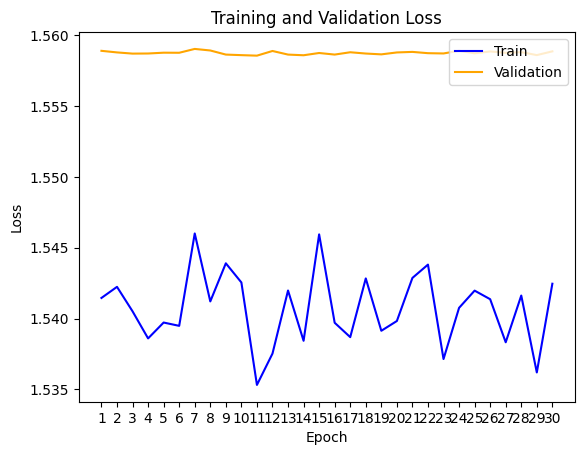

Test Loss: 1.509361
Test Accuracy of Classes

destroyed	: 77% 	 (828/1068)
major-damage	: 0% 	 (11/3500)
minor-damage	: 0% 	 (0/4623)
no-damage	: 40% 	 (4066/10108)

Test Accuracy of Dataset: 	 25% 	 (4905/19299)
Accuracy : tensor(0.2542)
F1-score :  tensor(0.2503)
Precision :  tensor(0.3280)
Recall :  tensor(0.2542)
Saving ...


TypeError: 'datetime.date' object is not callable

In [118]:
test_preds, test_lbls = train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all,
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all,)

### Configuration 2

In [123]:
lambda_wd = 0.011009637651263606
lrs = 0.00097
epoches = 30
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs, weight_decay=lambda_wd, amsgrad=True)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00097
    maximize: False
    weight_decay: 0.011009637651263606
)


Device available :  mps
Epoch: 1
	 Training Loss: 1.130532 	 Validation Loss: 1.197153
Epoch: 2
	 Training Loss: 1.073889 	 Validation Loss: 1.089152
Epoch: 3
	 Training Loss: 1.056796 	 Validation Loss: 1.151440
Epoch: 4
	 Training Loss: 1.048277 	 Validation Loss: 1.092218
Epoch: 5
	 Training Loss: 1.046585 	 Validation Loss: 1.120420
Epoch: 6
	 Training Loss: 1.037006 	 Validation Loss: 1.125893
Epoch: 7
	 Training Loss: 1.035802 	 Validation Loss: 1.056179
Epoch: 8
	 Training Loss: 1.034779 	 Validation Loss: 1.124428
Epoch: 9
	 Training Loss: 1.022927 	 Validation Loss: 1.072786
Epoch: 10
	 Training Loss: 1.018880 	 Validation Loss: 1.150869
Epoch: 11
	 Training Loss: 1.022918 	 Validation Loss: 1.120842
Epoch: 12
	 Training Loss: 1.024291 	 Validation Loss: 1.146268
Epoch: 13
	 Training Loss: 1.016856 	 Validation Loss: 1.094280
Epoch: 14
	 Training Loss: 1.020302 	 Validation Loss: 1.105429
Epoch: 15
	 Training Loss: 1.018703 	 Validation Loss: 1.115985
Epoch: 16
	 Training Loss

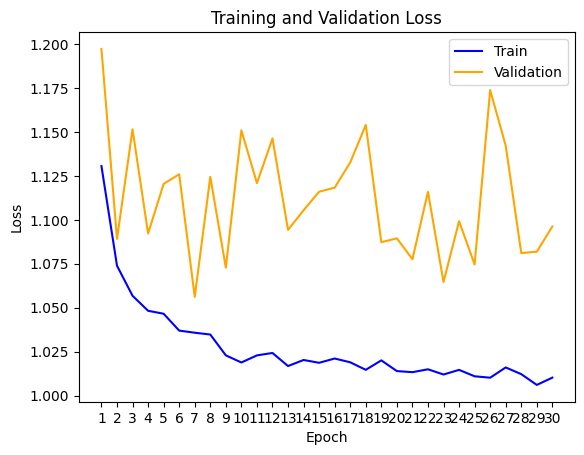

Test Loss: 1.095068
Test Accuracy of Classes

destroyed	: 71% 	 (762/1068)
major-damage	: 47% 	 (1649/3500)
minor-damage	: 55% 	 (2562/4623)
no-damage	: 50% 	 (5147/10108)

Test Accuracy of Dataset: 	 52% 	 (10120/19299)
Accuracy : tensor(0.5244)
F1-score :  tensor(0.5413)
Precision :  tensor(0.6009)
Recall :  tensor(0.5244)
Saving ...
Started : Saving the trained Model


NameError: name 'filename' is not defined

In [124]:
test_preds, test_lbls = train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all,
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

### Configuration 4

In [129]:
lambda_wd = 0.009909637651263606
lrs = 0.00097
epoches = 30
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs, weight_decay=lambda_wd, amsgrad=True)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00097
    maximize: False
    weight_decay: 0.009909637651263606
)


Device available :  mps
Epoch: 1
	 Training Loss: 1.009238 	 Validation Loss: 1.091712
Epoch: 2
	 Training Loss: 1.008922 	 Validation Loss: 1.162033
Epoch: 3
	 Training Loss: 1.010725 	 Validation Loss: 1.079898
Epoch: 4
	 Training Loss: 1.006110 	 Validation Loss: 1.098621
Epoch: 5
	 Training Loss: 1.007451 	 Validation Loss: 1.107200
Epoch: 6
	 Training Loss: 1.005764 	 Validation Loss: 1.043184
Epoch: 7
	 Training Loss: 1.009514 	 Validation Loss: 1.089875
Epoch: 8
	 Training Loss: 1.004771 	 Validation Loss: 1.095358
Epoch: 9
	 Training Loss: 1.008872 	 Validation Loss: 1.141060
Epoch: 10
	 Training Loss: 1.005422 	 Validation Loss: 1.119335
Epoch: 11
	 Training Loss: 1.008311 	 Validation Loss: 1.106979
Epoch: 12
	 Training Loss: 1.012810 	 Validation Loss: 1.092168
Epoch: 13
	 Training Loss: 1.010772 	 Validation Loss: 1.103268
Epoch: 14
	 Training Loss: 1.002935 	 Validation Loss: 1.085302
Epoch: 15
	 Training Loss: 1.010493 	 Validation Loss: 1.147770
Epoch: 16
	 Training Loss

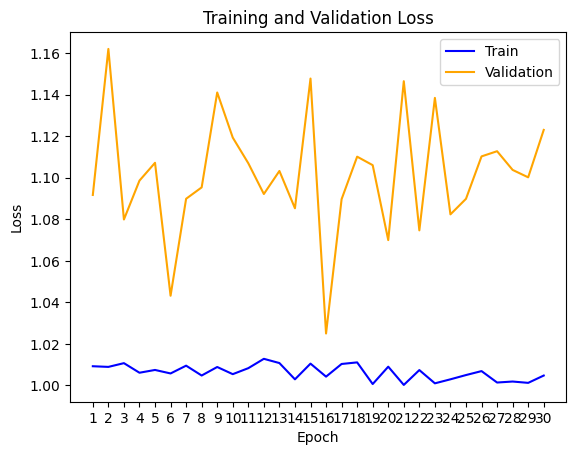

Test Loss: 1.105134
Test Accuracy of Classes

destroyed	: 76% 	 (814/1068)
major-damage	: 41% 	 (1442/3500)
minor-damage	: 46% 	 (2157/4623)
no-damage	: 56% 	 (5693/10108)

Test Accuracy of Dataset: 	 52% 	 (10106/19299)
Accuracy : tensor(0.5237)
F1-score :  tensor(0.5425)
Precision :  tensor(0.5917)
Recall :  tensor(0.5237)
Saving ...
vit2024-04-04.pkl
Started : Saving the trained Model
Finished : Saving the trained Model
Finished ...


In [132]:
test_preds, test_lbls = train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all,
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

In [133]:
os.getcwd()

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio'

### Configuration 5

In [134]:
lambda_wd = 0.0075
lrs = 0.00097
epoches = 30
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs, weight_decay=lambda_wd, amsgrad=True)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00097
    maximize: False
    weight_decay: 0.0075
)


Device available :  mps
Epoch: 1
	 Training Loss: 1.005352 	 Validation Loss: 1.078918
Epoch: 2
	 Training Loss: 1.010393 	 Validation Loss: 1.133997
Epoch: 3
	 Training Loss: 1.003065 	 Validation Loss: 1.092079
Epoch: 4
	 Training Loss: 1.003894 	 Validation Loss: 1.039113
Epoch: 5
	 Training Loss: 1.000157 	 Validation Loss: 1.109602
Epoch: 6
	 Training Loss: 1.003504 	 Validation Loss: 1.075525
Epoch: 7
	 Training Loss: 1.007039 	 Validation Loss: 1.126586
Epoch: 8
	 Training Loss: 1.003708 	 Validation Loss: 1.123103
Epoch: 9
	 Training Loss: 1.009842 	 Validation Loss: 1.067721
Epoch: 10
	 Training Loss: 1.006023 	 Validation Loss: 1.056678
Epoch: 11
	 Training Loss: 1.002732 	 Validation Loss: 1.115706
Epoch: 12
	 Training Loss: 1.004267 	 Validation Loss: 1.138317
Epoch: 13
	 Training Loss: 0.998679 	 Validation Loss: 1.124690
Epoch: 14
	 Training Loss: 1.000868 	 Validation Loss: 1.088002
Epoch: 15
	 Training Loss: 1.005871 	 Validation Loss: 1.141755
Epoch: 16
	 Training Loss

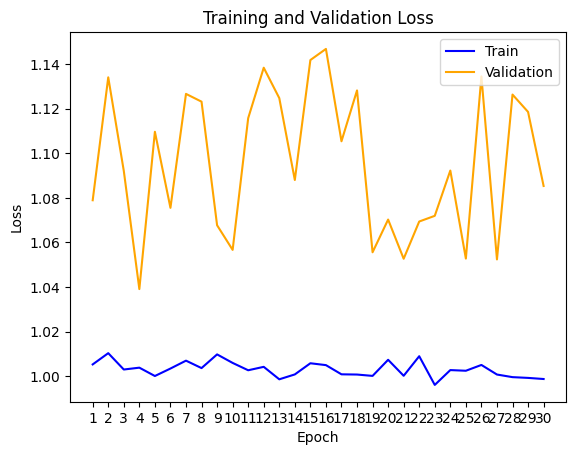

Test Loss: 1.078319
Test Accuracy of Classes

destroyed	: 72% 	 (773/1068)
major-damage	: 40% 	 (1405/3500)
minor-damage	: 56% 	 (2611/4623)
no-damage	: 54% 	 (5521/10108)

Test Accuracy of Dataset: 	 53% 	 (10310/19299)
Accuracy : tensor(0.5342)
F1-score :  tensor(0.5487)
Precision :  tensor(0.5929)
Recall :  tensor(0.5342)
Saving ...
vit2024-04-04.pkl
Started : Saving the trained Model
Finished : Saving the trained Model
Finished ...


In [135]:
test_preds, test_lbls = train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all,
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

### Configuration 6

In [137]:
lambda_wd = 0.0065
lrs = 0.00097
epoches = 30
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs, weight_decay=lambda_wd)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00097
    maximize: False
    weight_decay: 0.0065
)


Device available :  mps
Epoch: 1
	 Training Loss: 0.997728 	 Validation Loss: 1.074065
Epoch: 2
	 Training Loss: 1.003639 	 Validation Loss: 1.121102
Epoch: 3
	 Training Loss: 1.004264 	 Validation Loss: 1.064678
Epoch: 4
	 Training Loss: 1.001620 	 Validation Loss: 1.104685
Epoch: 5
	 Training Loss: 1.008649 	 Validation Loss: 1.054546
Epoch: 6
	 Training Loss: 1.000280 	 Validation Loss: 1.046461
Epoch: 7
	 Training Loss: 0.993283 	 Validation Loss: 1.047935
Epoch: 8
	 Training Loss: 1.002361 	 Validation Loss: 1.122898
Epoch: 9
	 Training Loss: 0.999351 	 Validation Loss: 1.118412
Epoch: 10
	 Training Loss: 1.005375 	 Validation Loss: 1.081134
Epoch: 11
	 Training Loss: 1.004732 	 Validation Loss: 1.082148
Epoch: 12
	 Training Loss: 1.002781 	 Validation Loss: 1.090557
Epoch: 13
	 Training Loss: 1.002464 	 Validation Loss: 1.061653
Epoch: 14
	 Training Loss: 0.994801 	 Validation Loss: 1.107533
Epoch: 15
	 Training Loss: 1.002760 	 Validation Loss: 1.060878
Epoch: 16
	 Training Loss

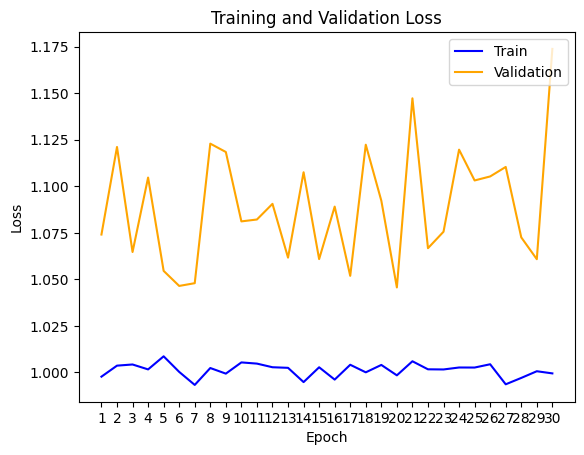

Test Loss: 1.172503
Test Accuracy of Classes

destroyed	: 74% 	 (800/1068)
major-damage	: 60% 	 (2104/3500)
minor-damage	: 45% 	 (2120/4623)
no-damage	: 39% 	 (4031/10108)

Test Accuracy of Dataset: 	 46% 	 (9055/19299)
Accuracy : tensor(0.4692)
F1-score :  tensor(0.4880)
Precision :  tensor(0.6064)
Recall :  tensor(0.4692)
Saving ...
vit2024-04-04.pkl
Started : Saving the trained Model
Finished : Saving the trained Model
Finished ...


In [138]:
test_preds, test_lbls = train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all,
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

### Misc

In [ ]:
best_val_accuracy, best_val_f1_score, best_val_precision, best_val_recall = None, None, None, None
best_val_accuracy_trial, best_val_f1_score_trial, best_val_precision_trial, best_val_recall_trial = None, None, None, None


for t, n in enumerate(study.trials):
    print(f'trial: {t}, params: {n.params}, values: {n.values}')
    
    accuracy, f1_score, precision, recall = n.values[0], n.values[1], n.values[2], n.values[3]

    if best_val_accuracy is None or accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_val_accuracy_trial = t

    if best_val_f1_score is None or f1_score < best_val_f1_score:
        best_val_f1_score = f1_score
        best_val_f1_score_trial = t

    if best_val_precision is None or precision < best_val_f1_score:
        best_val_precision = precision
        best_val_precision_trial = t
        
    if best_val_recall is None or recall < best_val_recall_trial:
        best_val_recall = recall
        best_val_recall_trial = t

print(f'\nbest trial by accuracy: {best_val_accuracy_trial}')
print(f'best trial by F1-score    : {best_val_f1_score_trial}\n')
print(f'best trial by precision    : {best_val_precision_trial}\n')
print(f'best trial by recall    : {best_val_recall_trial}\n')

# if best_val_accuracy_trial == best_val_loss_trial:
#     print(f'best trial : {best_val_accuracy_trial}')